In [17]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [15]:
from textrec.paths import paths
from textrec import analysis_util, util
reload(analysis_util), reload(util), reload()

(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>)

In [18]:
images = util.get_coco_captions()
images_by_split = toolz.groupby('split', images)

In [80]:
id2img = {img['cocoid']: img for img in images}
id2url = util.get_coco_id2url()

In [55]:
def show_images(indices, show_captions=True, show_label=True, max_width=200):
    def img(idx):
        img = id2img[idx]
        if show_captions:
            captions = '\n'.join(
                '<div>{}</div>'.format(sent)
                for sent in toolz.pluck('raw', img['sentences'])
            )
        else:
            captions = ''
        label = '<div>{}/{}</div>'.format(img['split'], img['cocoid']) if show_label else ''
        return '<div style="display: inline-block;">{}<img src="{}" style="max-width: {}px">{}</div>'.format(
            label, id2url[img['cocoid']], max_width, captions)

    return '\n'.join(img(idx) for idx in indices)

# Set of similar images

In [21]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [22]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]

In [56]:
query_caption = 'a cat sitting next to a glass bowl, looking up to the camera'
print(query_caption)
image_set = get_similar_images(query_caption)
HTML(show_images(image_set, show_captions=False, show_label=False, max_width=200))

a cat sitting next to a glass bowl, looking up to the camera


# Aside: Which of the captions is most discriminative for a single one of those images

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

In [92]:
import seaborn as sns

In [98]:
cmap = sns.choose_colorbrewer_palette('d')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

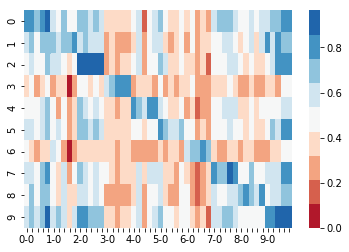

In [113]:
image_vectors = cap_vectorizer.transform([util.join_captions(id2img[id]) for id in image_set])
individual_cap_vectors = cap_vectorizer.transform([' '.join(sent['tokens']) for id in image_set for sent in id2img[id]['sentences']])
cap_srcs_txt = [f'{i}-{j}' if j == 0 else '' for i, id in enumerate(image_set) for j, sent in enumerate(id2img[id]['sentences'])]
cap_srcs = [(i,j) for i, id in enumerate(image_set) for j, sent in enumerate(id2img[id]['sentences'])]
similarities = image_vectors.dot(individual_cap_vectors.T).A
sns.heatmap(similarities, cmap=cmap, xticklabels=cap_srcs_txt);


In [118]:
dynamic_range = np.max(similarities, axis=0) - np.min(similarities, axis=0)
for k in np.argsort(dynamic_range):
    i, j= cap_srcs[k]
    print(id2img[image_set[i]]['sentences'][j]['raw'])

A cat sitting on top of the table beside a dish. 
an orange and white cat laying on a brown table
A small cat sitting under a wooden table.
A black and white cat sitting on top of a table.
a close up of a cat near a bowl
A cat is looking at an empty bowl on the floor.
A cat sitting in a bowl on a table looking at the camera.
a cat sitting on a table next to a colorful bowl
 A cat sitting on the floor near a bag.
A cat sitting in front of his food bowl looking at the camera.
A brown and white cat sitting next to a glass.
A golden colored cat sitting next to a bowl.
A cat staring at the bottom of a brown bowl. 
A gray cat laying on the floor next to a food dish.
A grey cat sitting in a blue bowl
A cat peering into a wooden bowl which is sitting on a table.
a brown cat sitting inside a fancy bowl
A ginger cat lying on a table next to a bowl
A large orange cat sitting in a white glass bowl.
A black cat is standing next to a bowl on a table
There is a adult cat that is sitting in a bowl
A c

# Back on track

In [119]:
stim_pairs = json.load(open(paths.data / 'stimulusPairs.json'))

In [248]:
stim_idx = 11
print('{},{}'.format(stim_pairs[stim_idx][1]['id'], stim_pairs[stim_idx][1]['url']))

image_set = get_similar_images(util.join_captions(id2img[stim_pairs[stim_idx][0]['id']]))

440500,http://images.cocodataset.org/train2017/000000440500.jpg


In [237]:
HTML(show_images(image_set, show_captions=False, show_label=True, max_width=200))

In [239]:
target_idx = np.random.choice(len(image_set))
target = image_set[target_idx]

In [240]:
def gen_cap(target, n_words=5):
    cap = []
    for i in range(n_words):
        recs = onmt_model_2.get_recs('coco_cap', str(target), cap)
        cap.append(recs[0])
    return cap

In [241]:
print(' '.join(gen_cap(target, n_words=5)))

a small bird perched on


In [243]:
print(' '.join(gen_cap(target, n_words=10)))

a small bird perched on a branch of a tree


In [245]:
def do_guess():
    for i in range(5):
        guess = int(input('guess? '))
        if guess == target:
            return i + 1
    return ':('
do_guess()

guess? 280480
guess? 128791
guess? 0
guess? 0
guess? 0


':('

In [246]:
target

234834

# Evaluate prob of each image in target set given caption

In [30]:
coco_cap = onmt_model_2.models['coco_cap']

In [31]:
imgdata_h5_all = paths.top_level / 'models-aside' / 'feats_by_imgid.h5'

In [58]:
paths.imgdata_h5 = imgdata_h5_all

In [32]:
import h5py
f = h5py.File(str(imgdata_h5_all))

def load_vecs(imgids, num_objs=36, feature_dim=2048):
    batch_size = len(imgids)
    vecs = np.empty((num_objs, batch_size, feature_dim))
    for i, idx in enumerate(imgids):
        vecs[:, i, :] = f[str(idx)][:]
    return Variable(torch.FloatTensor(vecs), volatile=True)


def encode_vecs(self, vecs):
    # vecs: objs x batch_size x feature_dim
    mean_feature = torch.mean(vecs, dim=0)  # batch_size x feature_dim

    # Construct the hidden and cell states.
    hidden_state = F.tanh(self.init_hidden(mean_feature))
    cell_state = F.tanh(self.init_cell(mean_feature))
    # hidden_state: batch_size x rnn_size

    # To make this look like the output of a sequence RNN, states need to
    # have an extra first dimension (per decoder layer) and be packed in a
    # tuple.

    enc_final = (
        hidden_state.unsqueeze(0),
        cell_state.unsqueeze(0)
    )

    return enc_final, vecs

vecs = load_vecs(image_set)
encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)

In [35]:
coco_cap.fields['tgt'].preprocess(query_caption)

['a',
 'cat',
 'sitting',
 'next',
 'to',
 'a',
 'glass',
 'bowl,',
 'looking',
 'up',
 'to',
 'the',
 'camera']

In [42]:
def eval_logprobs_varying_image(model, imgids, tgt_field, tgt_text):
    batch_size = len(imgids)

    vecs = load_vecs(image_set)
    encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)

    decoder_state = model.decoder.init_decoder_state(vecs, memory_bank=memory_bank, encoder_final=encoder_final)
#    decoder_state.repeat_beam_size_times(batch_size)
#    memory_bank = memory_bank.repeat(1, batch_size, 1)

    # "process" handles padding and numericalization
    tgt = tgt_field.process([tgt_text] * batch_size, device=-1, train=False)
    pad_idx = tgt_field.vocab.stoi[tgt_field.pad_token]
    
    # Decoder wants an extra dim for extra features.
    dec_out, dec_states, attn = model.decoder(tgt[:-1].unsqueeze(2), memory_bank, decoder_state)
    logits = model.generator(dec_out).contiguous()
    seq_len, batch_size_2, num_vocab = logits.shape
    assert batch_size == batch_size_2
    losses = F.nll_loss(logits.view(seq_len * batch_size, num_vocab), tgt[1:].view(seq_len * batch_size), reduce=False)
    mask = tgt[1:].eq(pad_idx)
    losses = losses.view(seq_len, batch_size).masked_fill(mask, 0).data.sum(0)
    length = (~mask.data).long().sum(0)
    return losses / length.float()

losses_by_img = eval_logprobs_varying_image(
    coco_cap.model,
    image_set,
    coco_cap.fields['tgt'],
    coco_cap.fields['tgt'].preprocess(query_caption)
).numpy()
losses_by_img

array([4.251428 , 4.11986  , 4.104523 , 4.046769 , 3.904194 , 3.8581712,
       3.8271136, 3.976628 , 4.283532 , 4.273225 ], dtype=float32)

In [43]:
np.argmin(losses_by_img)

6

In [46]:
HTML(show_images([image_set[idx] for idx in np.argsort(losses_by_img)]))

# Do more specific captions get scored higher?

In [250]:
stim_idx = 1
print('{},{}'.format(stim_pairs[stim_idx][1]['id'], stim_pairs[stim_idx][1]['url']))
image_set = get_similar_images(util.join_captions(id2img[stim_pairs[stim_idx][0]['id']]))
HTML(show_images(image_set, show_captions=False, show_label=True, max_width=200))

301595,http://images.cocodataset.org/train2017/000000301595.jpg


In [292]:
generic_caption = 'a bathroom with a toilet'
specific_captions = [
    'a brown towel hanging on', 'a brown towel hangs on',
    'stone sink counter glass shower', 'a modern bathroom with stone',
    'black and white tiled shower', 'a shower with black and',
    'ledge behind open toilet seat', 'a toilet with lid up',
    'open sliding shower behind toilet', 'a bathroom with beige floor',
    'adjustable shower head in corner', 'a bathroom with cabinets under',
    'spacious white symmetrical shower glass', 'a large bright white shower',
    'towel hanger over radiator beside', 'a dim bathroom with small',
    'green towel on shower door', 'two framed photos hang above',
    'white towel on shower door', 'a bathroom with a closed' #(shower)
]
candidate_captions = specific_captions + [generic_caption]

In [293]:
def eval_logprobs_simple(model, imgid, tokens, tgt_vocab):
    vecs = load_vecs([imgid])
    encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)
    decoder_state = model.decoder.init_decoder_state(vecs, memory_bank=memory_bank, encoder_final=encoder_final)

    tgt = Variable(torch.LongTensor([tgt_vocab.stoi[tok] for tok in tokens]).unsqueeze(1).unsqueeze(1))
    dec_out, dec_states, attn = model.decoder(tgt[:-1], memory_bank, decoder_state)
    logits = model.generator(dec_out)
    return F.nll_loss(logits.squeeze(1), tgt[1:].squeeze(1).squeeze(1), reduce=True, size_average=False).data[0]

for_cap_0=[
    eval_logprobs_simple(coco_cap.model, imgid, [onmt.io.BOS_WORD] + specific_captions[0].split(), tgt_field.vocab)
    for imgid in image_set]

In [294]:
for_cap_0

[18.293432235717773,
 21.099390029907227,
 21.52071762084961,
 22.68265151977539,
 20.42866325378418,
 19.899789810180664,
 21.961589813232422,
 21.88710594177246,
 17.45467185974121,
 21.346843719482422]

In [295]:
def eval_logprobs_many(model, tgt_field, imgids, texts, preproc=True, use_eos=False):
    batch_size = len(imgids)
    assert len(texts) == batch_size
    
    vecs = load_vecs(image_set)

    if preproc:
        texts = [tgt_field.preprocess(text) for text in texts]

    # "process" handles padding and numericalization
    tgt = tgt_field.process(texts, device=-1, train=False)
    pad_idx = tgt_field.vocab.stoi[tgt_field.pad_token]
    
    if not use_eos:
        tgt = tgt[:-1]
    
    encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)
    decoder_state = model.decoder.init_decoder_state(vecs, memory_bank=memory_bank, encoder_final=encoder_final)
    
    # Run decoder
    dec_out, dec_states, attn = model.decoder(
        tgt[:-1].unsqueeze(2), # Decoder wants an extra dim for extra features.
        memory_bank,
        decoder_state)
    # Run generator.
    logits = model.generator(dec_out).contiguous()
    seq_len, batch_size_2, num_vocab = logits.shape
    assert batch_size == batch_size_2

    # Compute nll loss, ignoring padding
    losses = F.nll_loss(logits.view(seq_len * batch_size, num_vocab), tgt[1:].view(seq_len * batch_size), reduce=False)
    losses = losses.view(seq_len, batch_size)
    return losses.data.numpy().sum(axis=0)
#     mask = tgt[1:].eq(pad_idx)
#     losses = losses.masked_fill(mask, 0).data.sum(0)
#     length = (~mask.data).long().sum(0)
#     return (losses / length.float()).numpy()


tgt_field = coco_cap.fields['tgt']
losses_by_cap = np.array([
    eval_logprobs_many(coco_cap.model, tgt_field, image_set, [cap] * len(image_set))
    for cap in candidate_captions])
losses_by_cap

array([[18.29343  , 21.099392 , 21.520718 , 22.682652 , 20.428663 ,
        19.899786 , 21.961592 , 21.887108 , 17.454672 , 21.346844 ],
       [20.216093 , 21.459185 , 22.343819 , 23.25599  , 21.341995 ,
        22.416582 , 22.364853 , 23.664122 , 17.388132 , 22.698366 ],
       [39.53264  , 39.07738  , 36.840885 , 42.485302 , 39.422974 ,
        38.24522  , 38.46059  , 41.825882 , 37.69344  , 39.03945  ],
       [18.718346 , 13.342897 , 13.147852 , 13.75539  , 15.231123 ,
        14.895325 , 16.82951  , 17.202742 , 15.470121 , 14.835234 ],
       [15.346966 , 16.093561 , 11.594956 , 16.068754 , 13.552652 ,
        11.984193 , 13.903265 , 14.410566 , 15.057523 , 13.432005 ],
       [12.1750145, 13.041934 , 13.031655 , 14.190959 , 11.340078 ,
        12.464938 , 10.303768 , 14.346598 , 13.188343 , 15.135149 ],
       [35.806595 , 38.948387 , 37.09033  , 36.18179  , 36.957592 ,
        35.932285 , 39.402554 , 38.134346 , 40.44112  , 37.911705 ],
       [18.314875 , 17.092129 , 16.415756

In [296]:
[len(tgt_field.preprocess(cap)) for cap in candidate_captions]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [297]:
losses_by_cap.shape

(21, 10)

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

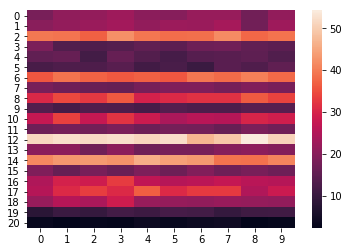

In [298]:
sns.heatmap(losses_by_cap)#, xticklabels=cap_srcs_txt);
np.argmin(losses_by_cap, axis=0)

No, the generic caption beats *every single one* of the more specific captions for *every single image*.

But how about the other way around: do the specific captions match up with the image that I wrote them for?

In [303]:
html=''
for desired, actual, cap in zip([i//2 for i in range(20)], np.argmin(losses_by_cap, axis=1), candidate_captions):
    if desired != actual:
        html += (
            '<div>{}<br><img src="{}" style="display:inline-block;max-width: {}px"><img src="{}" style="display:inline-block;max-width: {}px">'
        ).format(cap, id2url[image_set[desired]], 200, id2url[image_set[actual]], 200)
HTML(html)

No, and those mismatches don't make sense.

# Other

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import onmt.io


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import torch.nn.functional as F

In [4]:
from IPython.display import Image, HTML

In [6]:
for img in images:
    img['all_captions'] = '\n'.join(sent['raw'].replace('\n', ' ') for sent in img['sentences'])

In [7]:
len(images)

123287

In [8]:
valid_images = [img for img in images if img['split'] == 'val']
len(valid_images)

5000

A few images have 6 sentences rather than the normal 5. We'll ignore that.

In [9]:
[(img['cocoid'], len(img['sentences'])) for img in valid_images if len(img['sentences']) != 5]

[(96493, 6),
 (510643, 6),
 (92771, 6),
 (204311, 6),
 (567315, 6),
 (100008, 6),
 (320428, 6),
 (449312, 6),
 (459032, 6),
 (216369, 6)]

In [10]:
val_imgids = [img['cocoid'] for img in valid_images for sent in img['sentences']]
val_caps = [sent['tokens'] for img in valid_images for sent in img['sentences']]
len(val_caps)

25010

# Use the OpenNMT models to score likelihoods.

In [13]:
from textrec import onmt_model_2
from textrec.paths import paths

Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


In [23]:
def eval_logprob(model, src, encoder_final, memory_bank, tgt_tokens, tgt_vocab):
    decoder_state = coco_lm.model.decoder.init_decoder_state(src, memory_bank=memory_bank, encoder_final=encoder_final)
    tgt_tokens = [onmt.io.BOS_WORD] + tgt_tokens + [onmt.io.EOS_WORD]
    tgt = Variable(torch.LongTensor([tgt_vocab.stoi[tok] for tok in tgt_tokens]).unsqueeze(1).unsqueeze(1))
    dec_out, dec_states, attn = model.decoder(tgt[:-1], memory_bank, decoder_state)
    logits = model.generator(dec_out)
    return F.nll_loss(logits.squeeze(1), tgt[1:].squeeze(1).squeeze(1), reduce=True).data[0]

encoder_final, memory_bank = coco_lm.model.encoder(lm_src)
for cap in val_caps[:5]:
    print(eval_logprob(coco_lm.model, lm_src, encoder_final, memory_bank, cap, lm_tgt_vocab))

4.055610179901123
1.9828158617019653
4.326562404632568
3.957759141921997
2.8188583850860596


In [24]:
%timeit eval_logprob(coco_lm.model, lm_src, encoder_final, memory_bank, cap, lm_tgt_vocab)

129 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
len(cap)

10

In [91]:
def eval_logprob_batched(model, src, tgt_field, encoder_final, memory_bank, batch, divide_by_length=True):
    batch_size = len(batch)

    # We need to redo this each time because decoder mutates the state that's passed to it :(
    decoder_state = coco_lm.model.decoder.init_decoder_state(src, memory_bank=memory_bank, encoder_final=encoder_final)
    decoder_state.repeat_beam_size_times(batch_size)
    memory_bank = memory_bank.repeat(1, batch_size, 1)

    # "process" handles padding and numericalization
    tgt = tgt_field.process(batch, device=-1, train=False)
    pad_idx = tgt_field.vocab.stoi[tgt_field.pad_token]
    
    # Decoder wants an extra dim for extra features.
    dec_out, dec_states, attn = model.decoder(tgt[:-1].unsqueeze(2), memory_bank, decoder_state)
    logits = model.generator(dec_out).contiguous()
    seq_len, batch_size_2, num_vocab = logits.shape
    assert batch_size == batch_size_2
    losses = F.nll_loss(logits.view(seq_len * batch_size, num_vocab), tgt[1:].view(seq_len * batch_size), reduce=False)
    mask = tgt[1:].eq(pad_idx)
    losses = losses.view(seq_len, batch_size).masked_fill(mask, 0).data.sum(0)
    if divide_by_length:
        length = (~mask.data).long().sum(0)
        return losses / length.float()
    else:
        return losses

encoder_final, memory_bank = coco_lm.model.encoder(lm_src)
batch_size = 32
unconditional_losses = eval_logprob_batched(coco_lm.model, lm_src, coco_lm.fields['tgt'], encoder_final, memory_bank, val_caps[:batch_size]).numpy()
unconditional_losses

array([4.05561  , 1.9828162, 4.3265624, 3.9577591, 2.8188581, 2.1887002,
       2.9275367, 3.178268 , 3.394708 , 3.3064091, 2.8171813, 3.260916 ,
       2.3935277, 3.4049525, 3.1746356, 1.4956913, 3.4236114, 6.401656 ,
       2.3428607, 6.3635745, 3.0610476, 4.6592226, 4.3822927, 3.0525162,
       3.3139853, 2.8301854, 1.9576231, 2.3530643, 1.6457199, 2.0004718,
       1.5807973, 1.2306131], dtype=float32)

In [77]:
import pandas as pd

In [87]:
pd.set_option('display.max_colwidth', -1)